In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import textwrap
import re
from collections import Counter

In [2]:
def search_root_dir(target_folder):
    for parent in Path.cwd().parents:
        if target_folder in os.listdir(parent):
            return parent / target_folder
    return None

# define target folder
target_folder = 'TechnocraticDemocracies'
root_dir = search_root_dir(target_folder)

# set data and output directories
data_dir = root_dir / '01 Raw Data' / 'fiscal_rules'
plot_dir = root_dir / '04 Plots'

# print directories
print('Data directory: ', data_dir)
print('Plot directory: ', plot_dir)

# check if they exist; if they do not, create them
if not data_dir.exists():
    print('Data directory does not exist.')

if not plot_dir.exists():
    print('Plot directory does not exist.')
    os.makedirs(plot_dir)

Data directory:  c:\Users\User\OneDrive\Documentos\Papers_Articles_Self\TechnocraticDemocracies\01 Raw Data\fiscal_rules
Plot directory:  c:\Users\User\OneDrive\Documentos\Papers_Articles_Self\TechnocraticDemocracies\04 Plots
Data directory does not exist.


In [3]:
def clean_and_standardize_column_names(columns):
    """
    Cleans and standardizes column names by:
    - Joining multi-header columns with underscores
    - Removing all occurrences of 'unnamed_X' and 'level_X' placeholders
    - Removing special characters carefully
    - Replacing multiple underscores with a single underscore
    - Converting column names to lowercase
    - Ensuring uniqueness by appending a counter to duplicate names

    Parameters:
    columns (list or MultiIndex): List of column names (or MultiIndex)

    Returns:
    list: Cleaned and standardized column names
    """

    seen = Counter()
    cleaned_columns = []

    for col in columns:
        # print(f"Original column: {col}")

        # Flatten multi-index by joining with underscores, ignoring None/NaN values
        if isinstance(col, tuple):
            col = '_'.join([str(c).strip() for c in col if str(c).lower() not in ['nan', 'none', '', 'unnamed']])
        else:
            col = str(col).strip()

        # print(f"After flattening: {col}")

        # Convert to lowercase for consistency
        col = col.lower()
        # print(f"After lowercase conversion: {col}")

        # Replace special characters first
        col = re.sub(r'[^a-z0-9_]', '_', col)
        # print(f"After removing special characters: {col}")

        # Collapse multiple consecutive underscores into a single underscore
        col = re.sub(r'_+', '_', col)
        # print(f"After collapsing underscores: {col}")

        # Remove all occurrences of 'unnamed_x' and 'level_x' (after character handling)
        col = re.sub(r'(_?unnamed_\d+_?)+', '_', col)  # Remove unnamed_X
        col = re.sub(r'(_?level_\d+_?)+', '_', col)    # Remove level_X
        # print(f"After removing unnamed/level: {col}")

        # Remove leading or trailing underscores
        col = col.strip('_')
        # print(f"After trimming underscores: {col}")

        # Ensure uniqueness by appending a counter if necessary
        seen[col] += 1
        if seen[col] > 1:
            col = f"{col}_{seen[col] - 1}"
            # print(f"After ensuring uniqueness: {col}")

        cleaned_columns.append(col)

    return cleaned_columns

In [5]:
# import data 
fisc_rules = pd.read_excel(
    data_dir / 'imf_fiscal_rules_1985_2021.xlsx', 
    sheet_name='Rules', 
    header=[0, 1, 2, 3],  # Read first two rows as multi-index headers
    na_values='-'
)

# Drop any fully empty rows or columns
fisc_rules.dropna(axis=0, how='all', inplace=True)
fisc_rules.dropna(axis=1, how='all', inplace=True)

# Clean and standardize column names
fisc_rules.columns = clean_and_standardize_column_names(fisc_rules.columns)
# Print the cleaned column names
# print(fisc_rules.columns)

In [6]:
# create new variable for type of economy 
fisc_rules['type_of_economy'] = np.where(fisc_rules['additional_information_type_of_economy_advanced'] == 1, 'advanced',
                                         np.where(fisc_rules['additional_information_type_of_economy_emerging'] == 1, 'emerging',
                                                  np.where(fisc_rules['additional_information_type_of_economy_low_income'] == 1, 'low income', 'unknown')))

# for all columns starting with 'type_of_fiscal_rule_in_place' fill missing values with 0
fisc_rules.loc[:, fisc_rules.columns[fisc_rules.columns.str.startswith('type_of_fiscal_rule_in_place')]] = fisc_rules.loc[:, fisc_rules.columns[fisc_rules.columns.str.startswith('type_of_fiscal_rule_in_place')]].fillna(0)

# create variable for type of fiscal rule
fisc_rules['type_of_fiscal_rule_general'] = np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                     (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                     (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                     (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'BBR + ER + RR + DR',
                                                     np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                              (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                              (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                              (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'BBR + ER + DR',
                                                              np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                                       (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                                       (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                       (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'BBR + ER + RR',
                                                                       np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                                                (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                                                (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'BBR + DR + RR',
                                                                                np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                                                         (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                         (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                                                         (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'BBR + DR',
                                                                                         np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                                                                  (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                                  (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                                                  (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'BBR + RR',
                                                                                                  np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                           (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                                                                           (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                                                                           (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'ER + DR + RR',
                                                                                                           np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                                    (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                                                                                    (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                                                                                    (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'ER + DR',
                                                                                                                    np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                                             (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                                                                                             (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                                                                             (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'ER + RR',
                                                                                                                             np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                                                      (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                                                                      (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                                                                                                      (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'DR + RR',
                                                                                                                                      np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                                                                                                               (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                                                                                                               (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                                                                                               (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'BBR + ER',
                                                                                                                                               np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 1) & 
                                                                                                                                                        (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                                                                                        (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                                                                                                        (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'BBR',
                                                                                                                                                        np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                                                                                 (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 1) & 
                                                                                                                                                                 (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                                                                                                                 (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'ER',
                                                                                                                                                                 np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                                                                                          (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                                                                                                          (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 1) & 
                                                                                                                                                                          (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 0), 'DR',
                                                                                                                                                                          np.where((fisc_rules['type_of_fiscal_rule_in_place_bbr_budget_balance_rule'] == 0) & 
                                                                                                                                                                                   (fisc_rules['type_of_fiscal_rule_in_place_er_expenditure_rule'] == 0) & 
                                                                                                                                                                                   (fisc_rules['type_of_fiscal_rule_in_place_dr_debt_rule'] == 0) & 
                                                                                                                                                                                   (fisc_rules['type_of_fiscal_rule_in_place_rr_revenue_rule'] == 1), 'RR', 'None')))))))))))))))

# create a dummy variable for any type of fiscal rule in place
fisc_rules['any_fiscal_rule_in_place'] = np.where(fisc_rules['type_of_fiscal_rule_general'] == 'None', 0, 1)

# fill na values in columns starting with 'national_0_supranational_1' with 0
fisc_rules.loc[:, fisc_rules.columns[fisc_rules.columns.str.startswith('national_0_supranational_1')]] = fisc_rules.loc[:, fisc_rules.columns[fisc_rules.columns.str.startswith('national_0_supranational_1')]].fillna(0)

# create a dummy variable that records whether any of the fiscal rules in place are supranational
fisc_rules['any_supranational_fiscal_rule_in_place'] = np.where(
    np.logical_or.reduce((
        fisc_rules['national_0_supranational_1_both_2_bbr_budget_balance_rule'] == 1,
        fisc_rules['national_0_supranational_1_both_2_dr_debt_rule'] == 1,
        fisc_rules['national_0_supranational_1_both_2_er_expenditure_rule'] == 1,
        fisc_rules['national_0_supranational_1_both_2_rr_revenue_rule'] == 1
    )), 1, 0)

# total number of countries whose economies are classified as advanced, emerging, low income, or unknown per year (separate variable for each type of economy)
fisc_rules['total_number_countries_advanced'] = fisc_rules.groupby('identifiers_year')['type_of_economy'].transform(lambda x: (x == 'advanced').sum())
fisc_rules['total_number_countries_emerging'] = fisc_rules.groupby('identifiers_year')['type_of_economy'].transform(lambda x: (x == 'emerging').sum())
fisc_rules['total_number_countries_low_income'] = fisc_rules.groupby('identifiers_year')['type_of_economy'].transform(lambda x: (x == 'low income').sum())

# total number of countries per year 
fisc_rules['total_number_countries'] = fisc_rules.groupby('identifiers_year')['identifiers_country_name'].transform('count')

# compute total number of fiscal rules in place per year
fisc_rules['total_number_rules_in_place'] = fisc_rules.groupby('identifiers_year')['any_fiscal_rule_in_place'].transform('sum').reset_index(drop=True)

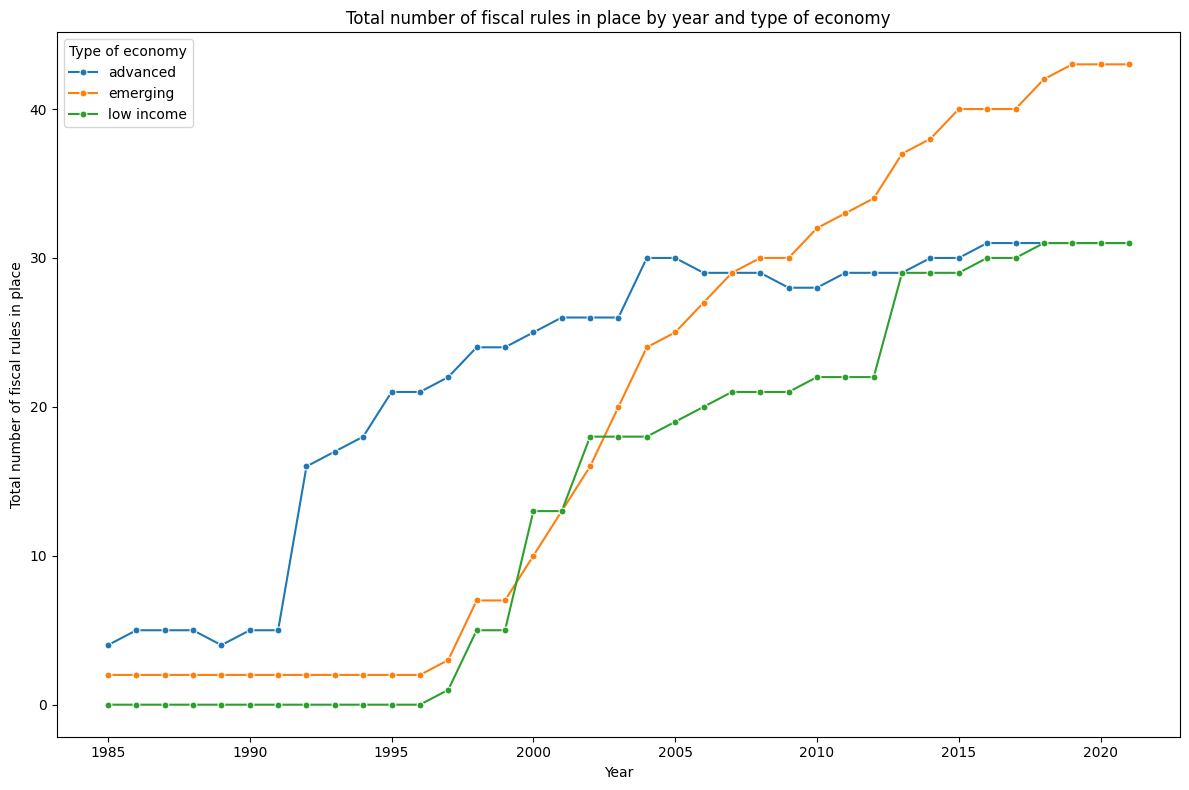

In [7]:
# plot total_cases by type_of_economy and year 
fisc_rules_grouped = fisc_rules.groupby(['identifiers_year', 'type_of_economy'])['any_fiscal_rule_in_place'].sum().reset_index()
# plot 
#sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.lineplot(data=fisc_rules_grouped, x='identifiers_year', y='any_fiscal_rule_in_place', hue='type_of_economy', marker='o', markersize=5)
plt.title('Total number of fiscal rules in place by year and type of economy')
plt.xlabel('Year')
plt.ylabel('Total number of fiscal rules in place')
plt.legend(title='Type of economy')
plt.tight_layout()
# plt.savefig(plot_dir / 'total_cases_by_type_of_economy.png')
plt.show()

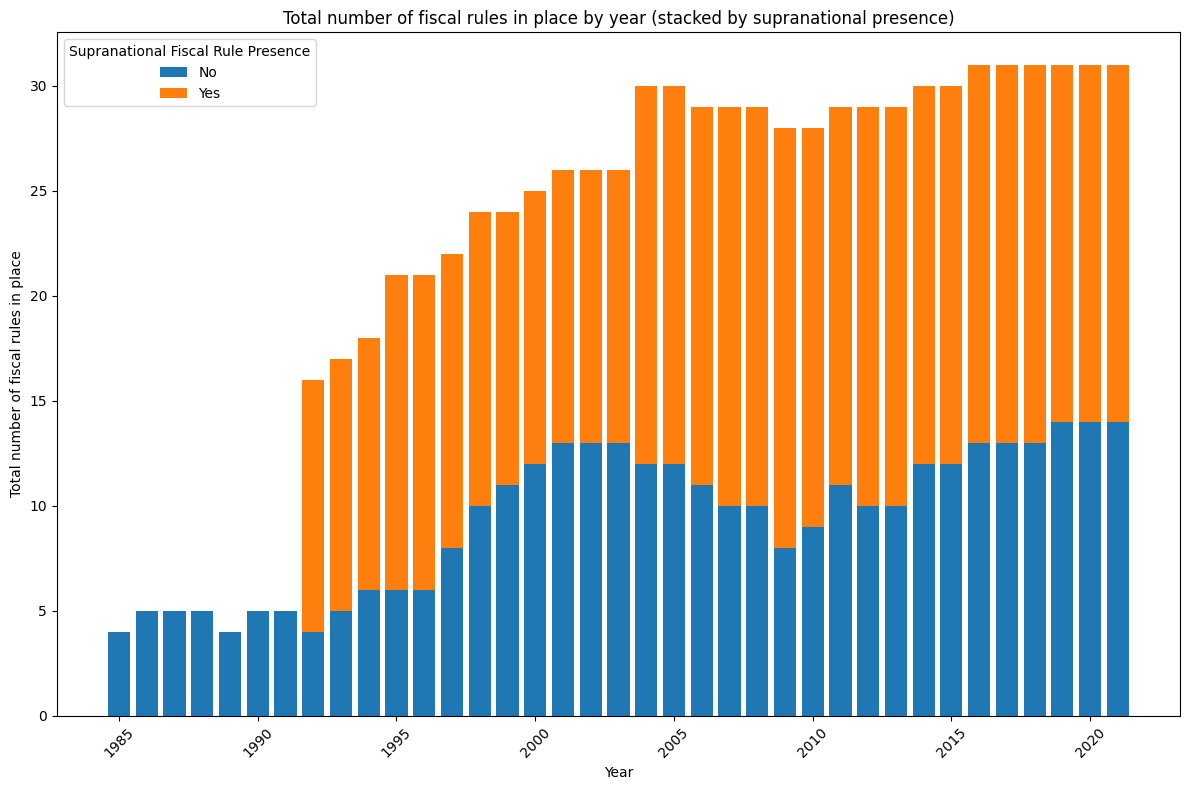

In [8]:
fisc_rules_advanced = fisc_rules[fisc_rules['type_of_economy'] == 'advanced']

# compute total number of cases by year and whether any fiscal rule in place is supranational
# Compute total number of cases by year and supranational fiscal rule presence
fisc_rules_adv_grouped = fisc_rules_advanced.groupby(
    ['identifiers_year', 'any_supranational_fiscal_rule_in_place']
)['any_fiscal_rule_in_place'].sum().unstack(fill_value=0).reset_index()

# Plot stacked bars using Matplotlib
plt.figure(figsize=(12, 8))

# Stacked bar chart
bottom_values = None
for col in fisc_rules_adv_grouped.columns[1:]:  # Skip year column
    plt.bar(
        fisc_rules_adv_grouped['identifiers_year'], 
        fisc_rules_adv_grouped[col], 
        bottom=bottom_values, 
        label=f'Supranational Rule: {col}'
    )
    # Update bottom values for stacking
    bottom_values = fisc_rules_adv_grouped[col] if bottom_values is None else bottom_values + fisc_rules_adv_grouped[col]

# Customize plot
plt.title('Total number of fiscal rules in place by year (stacked by supranational presence)')
plt.xlabel('Year')
plt.ylabel('Total number of fiscal rules in place')
plt.legend(title='Supranational Fiscal Rule Presence', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_43924\2527493044.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fisc_rules_long_grouped_adv['fiscal_rule'] = fisc_rules_long_grouped_adv['fiscal_rule'].replace({'type_of_fiscal_rule_in_place_er_expenditure_rule': 'Expenditure Rule',


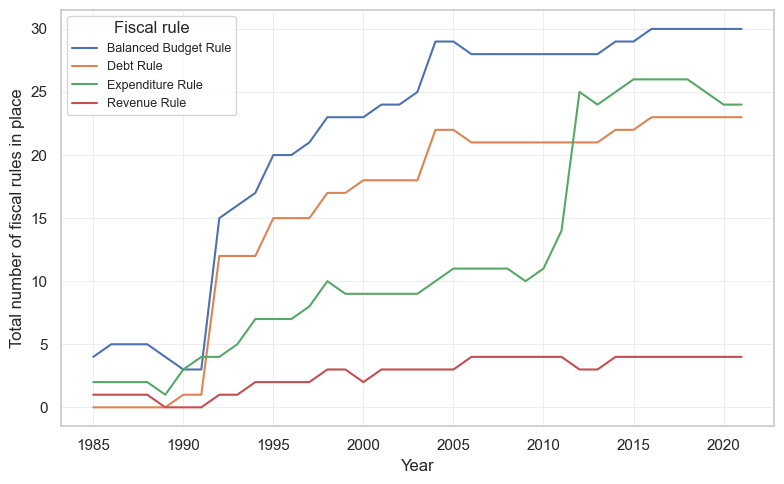

In [9]:
# set theme to whitegrid
sns.set_theme(style='whitegrid')

# pivot data long 
fisc_rules_long = fisc_rules.melt(id_vars=['identifiers_year', 'identifiers_country_name', 'type_of_economy'], value_vars=['type_of_fiscal_rule_in_place_er_expenditure_rule', 'type_of_fiscal_rule_in_place_bbr_budget_balance_rule', 'type_of_fiscal_rule_in_place_dr_debt_rule', 'type_of_fiscal_rule_in_place_rr_revenue_rule'], var_name='fiscal_rule', value_name='rule_in_place')

# aggregate by year, type of economy, and fiscal rule
fisc_rules_long_grouped = fisc_rules_long.groupby(['identifiers_year', 'type_of_economy', 'fiscal_rule'])['rule_in_place'].sum().reset_index()
fisc_rules_long_grouped_adv = fisc_rules_long_grouped[fisc_rules_long_grouped['type_of_economy'] == 'advanced']

# relabel fiscal rule variable
fisc_rules_long_grouped_adv['fiscal_rule'] = fisc_rules_long_grouped_adv['fiscal_rule'].replace({'type_of_fiscal_rule_in_place_er_expenditure_rule': 'Expenditure Rule',
                                                                                                'type_of_fiscal_rule_in_place_bbr_budget_balance_rule': 'Balanced Budget Rule',
                                                                                                'type_of_fiscal_rule_in_place_dr_debt_rule': 'Debt Rule',
                                                                                                'type_of_fiscal_rule_in_place_rr_revenue_rule': 'Revenue Rule'})


# plot total number of fiscal rules in place by year and type of fiscal rule
plt.figure(figsize=(8, 5))
ax = sns.lineplot(data=fisc_rules_long_grouped_adv, 
                  x='identifiers_year', 
                  y='rule_in_place', 
                  hue='fiscal_rule', 
                  errorbar=None)

# Adjust grid properties on the current axes
ax.grid(True, color='0.9', linewidth=0.5)
plt.title('')
plt.xlabel('Year')
plt.ylabel('Total number of fiscal rules in place')
plt.legend(title='Fiscal rule', fontsize=9, loc = 'upper left')
plt.tight_layout()
plt.savefig(plot_dir / 'total_cases_by_type_of_fiscal_rule_advanced.png', dpi = 300)
plt.show()